Análisis de performance de agentes - Búsqueda Local CSP
===

# Tiempo de ejecución

In [30]:
import NQueens
import random
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from time import time_ns

## Se llevará a cabo con la siguiente configuración:

In [31]:
algorithms = [NQueens.backtracking]
sizes = [4, 8, 10, 12, 15]
n_iterations = 30
random.seed(42)

---

## Correr simulación

In [32]:
def run_simulation(simulations, algorithms, size):
    # Run in each agent
    for algorithm in algorithms:
        # Run agent
        start = time_ns()
        _, best_h, iterations = algorithm(size)
        end = time_ns()
        
        # Append results in the siumlations dict
        simulations.append({
            'algorithm': algorithm.__name__,
            'size': size,
            'iterations': iterations,
            'time_ms': (end-start)/1e6
        })

In [33]:
# Using parallelism :D
with mp.Manager() as manager:
    simulations = manager.list() #List thread-safe. (overkill, find alternatives)
    pool = mp.Pool() #use all available cores, otherwise specify the number you want as an argument
    
    # Test iterations
    for size in sizes:
        for _ in range(n_iterations):
            pool.apply_async(run_simulation, args=(simulations, algorithms, size))

    # Wait for all threads to finish
    pool.close()
    pool.join()
    
    # Save it as a pandas dataframe
    simulations_df = pd.DataFrame(list(simulations))

simulations_df.to_csv('attachments/simulations.csv')
simulations_df

,algorithm,size,iterations,time_ms
0,backtracking,4,26,0.039320
1,backtracking,4,26,0.035330
2,backtracking,4,26,0.028610
3,backtracking,4,26,0.028980
4,backtracking,4,26,0.033390
...,...,...,...,...
145,backtracking,15,20280,7.869913
146,backtracking,15,20280,8.104554
147,backtracking,15,20280,11.278402
148,backtracking,15,20280,9.648243


## Análisis del performance de cada algorítmo

In [34]:
samples_list = []

for algorithm in algorithms:
    for size in sizes:
        sample_df = simulations_df.query(f'algorithm == "{algorithm.__name__}" and size == {size}')
        
        # Save saple report
        samples_list.append({
            'algorithm': algorithm.__name__,
            'size': size,
            'time_ms_avg': sample_df['time_ms'].mean(),
            'time_ms_std': sample_df['time_ms'].std(),
            'iter_avg': sample_df['iterations'].mean(),
            'iter_std': sample_df['iterations'].std()
        })

# Print table
samples_df = pd.DataFrame(samples_list)
samples_df.to_csv('attachments/samples.csv')
samples_df

,algorithm,size,time_ms_avg,time_ms_std,iter_avg,iter_std
0,backtracking,4,0.025839,0.006675,26.0,0.0
1,backtracking,8,0.307378,0.059674,876.0,0.0
2,backtracking,10,0.362732,0.058687,975.0,0.0
3,backtracking,12,1.139420,0.151917,3066.0,0.0
4,backtracking,15,10.765588,1.483250,20280.0,0.0


## Gráficos
### Boxplot - Tiempo empleado hasta llegar a una solución

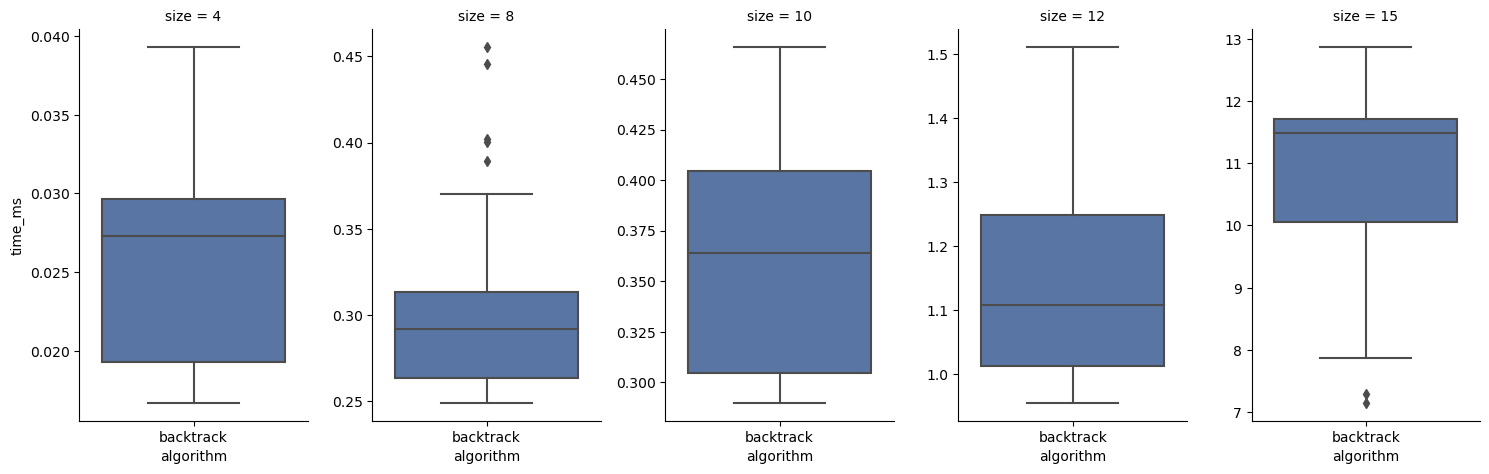

In [35]:
%matplotlib inline

grid1 = sns.FacetGrid(data=simulations_df, col='size', sharey=False)
grid1.map(sns.boxplot, 'algorithm', 'time_ms', order= [x.__name__ for x in algorithms], palette="deep")
grid1.set_xticklabels(['backtrack'])

grid1.fig.subplots_adjust(top=1.5)
grid1.savefig('attachments/time_by_algorithm.svg')